In [2]:
!pip install sentence-transformers torch googletrans pandas transformers accelerate legacy-cgi

In [5]:
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
from googletrans import Translator
import pandas as pd
import gc
import time


In [6]:
def get_model_configs():
    return [
        {'name': 'MiniLM (Translated)', 'path': 'all-MiniLM-L6-v2', 'type': 'sentence-transformer', 'requires_translation': True},
        {'name': 'LaBSE', 'path': 'sentence-transformers/LaBSE', 'type': 'sentence-transformer'},
        {'name': 'mBERT', 'path': 'bert-base-multilingual-cased', 'type': 'transformers'},
        {'name': 'XLM-RoBERTa', 'path': 'xlm-roberta-base', 'type': 'transformers'},
        {'name': 'MuRIL', 'path': 'google/muril-base-cased', 'type': 'transformers'},
        {'name': 'IndicBERT', 'path': 'ai4bharat/indic-bert', 'type': 'transformers'},
        {'name': 'Krutrim', 'path': 'Krutrim/Krutrim-specter-base-indic', 'type': 'transformers'},
        {'name': 'L3Cube-IndicSBERT', 'path': 'l3cube-pune/indic-sentence-bert-nli', 'type': 'sentence-transformer'},
        {'name': 'Multilingual-E5', 'path': 'intfloat/multilingual-e5-base', 'type': 'sentence-transformer'},
    ]

In [9]:
# wrapper for diff models
class ModelWrapper:
    def __init__(self, config):
        self.name = config['name']
        self.path = config['path']
        self.type = config['type']
        self.model = None
        self.tokenizer = None
        self._load_model()

    def _load_model(self):
        print(f"Loading {self.name} ({self.path})...")
        if self.type == 'sentence-transformer':
            self.model = SentenceTransformer(self.path)
        elif self.type == 'transformers':
            self.tokenizer = AutoTokenizer.from_pretrained(self.path)
            self.model = AutoModel.from_pretrained(self.path)
        self.model.eval()
        if torch.cuda.is_available():
            self.model.to('cuda')

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def encode(self, texts, batch_size=32, is_query=False):
        if 'E5' in self.name:
            prefix = 'query: ' if is_query else 'passage: '
            texts = [f"{prefix}{text}" for text in texts]

        if self.type == 'sentence-transformer':
            return self.model.encode(texts, convert_to_tensor=True, batch_size=batch_size, show_progress_bar=False)

        elif self.type == 'transformers':
            all_embeddings = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
                if torch.cuda.is_available():
                    encoded_input = {k: v.to('cuda') for k, v in encoded_input.items()}

                with torch.no_grad():
                    model_output = self.model(**encoded_input)

                batch_embeddings = self._mean_pooling(model_output, encoded_input['attention_mask'])
                all_embeddings.append(batch_embeddings.to('cpu'))

            return torch.cat(all_embeddings)


In [10]:
#  CORPUS 

def get_corpus_and_ground_truth():

    corpus = [
        #  Finance Cluster (12 docs) 
        # Doc 0: Safe, Long-term SIPs
        "म्यूचुअल फंड (एसआईपी) में लंबी अवधि के लिए सेवानिवृत्ति जैसे लक्ष्यों के लिए निवेश करने की एक सुरक्षित रणनीति।",
        # Doc 1: High-risk, Short-term trading
        "शेयर बाजार में डे-ट्रेडिंग के माध्यम से त्वरित लाभ कमाने के लिए उच्च जोखिम वाली रणनीतियाँ।",
        # Doc 2: Safest, Long-term US Bonds
        "As a sovereign security, United States Treasury Bonds are considered the safest possible investment for capital preservation over a long period, offering low but guaranteed returns.",
        # Doc 3: Highest-risk, Venture Capital
        "Venture Capital (VC) funding involves providing capital to startups with high growth potential, which is an extremely high-risk, illiquid investment.",
        # Doc 4: Safe, Mid-term Post Office Schemes (India)
        "இந்தியாவில் தபால் அலுவலக சேமிப்பு திட்டங்கள், அரசாங்கத்தால் ஆதரிக்கப்படும் மற்றும் நடுத்தர காலத்திற்கு பாதுகாப்பானவை.",
        # Doc 5: Illiquid, Long-term Real Estate
        "വാണിജ്യ റിയൽ എസ്റ്റേറ്റിലെ നിക്ഷേപം ദീർഘകാലത്തേക്ക് നല്ല വരുമാനം നൽകുമെങ്കിലും, അത് പെട്ടെന്ന് പണമാക്കി മാറ്റാൻ പ്രയാസമാണ്.",
        # Doc 6: ETFs vs Index Funds (Distractor)
        "A detailed comparison between Exchange-Traded Funds (ETFs) and Index Funds, focusing on expense ratios, tax efficiency, and trading flexibility.",
        # Doc 7: Public Provident Fund (PPF) (Safe, Long-term, Tax-saving)
        "पब्लिक प्रोविडेंट फंड (पीपीएफ) - भारत में एक सरकार समर्थित, कर-बचत योजना जो दीर्घकालिक धन संचय के लिए है।",
        # Doc 8: Derivatives/Options Trading (High-risk)
        "An introduction to financial derivatives like options and futures, which are complex instruments used for hedging or speculation against market movements.",
        # Doc 9: ELSS Mutual Funds (Tax-saving)
        "इक्विटी लिंक्ड सेविंग स्कीम्स (ईएलएसएस) - एक प्रकार का म्यूचुअल फंड जो धारा 80 सी के तहत कर लाभ प्रदान करता है।",
        # Doc 10 : Monolith vs Microservices
        "A comparison of monolith vs. microservices architecture for building scalable web applications, discussing the pros and cons of each approach.",
        # Doc 11 : Mobile App Dev: Native vs Cross-Platform
        "மொபைல் ஆப் டெவலப்மென்ட்: நேட்டிவ் (Native) மற்றும் கிராஸ்-பிளாட்ஃபார்ம் (Cross-Platform) رویکരدهای ஒப்பீடு.",

        #  Technology Cluster (8 docs) 
        # Doc 12: Generative AI
        "Generative AI models, such as GPT-4 and Midjourney, are designed to create new content like text, images, and music.",
        # Doc 13: Predictive AI
        "Predictive AI analyzes historical data to identify patterns and forecast future outcomes, commonly used in sales and stock market analysis.",
        # Doc 14: Computer Vision AI
        "कंप्यूटर विज़न एआई का उपयोग सुरक्षा कैमरा फुटेज में वस्तुओं की पहचान और ट्रैकिंग के लिए किया जाता है।",
        # Doc 15: AI Ethics Critique
        "வேலைக்கு ஆள் எடுக்கும் প্রক্রையில் செயற்கை நுண்ணறிவைப் பயன்படுத்துவதில் உள்ள நெறிமுறை சிக்கல்கள், குறிப்பாக पक्षपात தொடர்பான கவலைகள்.",
        # Doc 16: Reinforcement Learning (RL)
        "An overview of Reinforcement Learning, an area of machine learning where an agent learns to take actions in an environment to maximize cumulative reward.",
        # Doc 17: AI in Agriculture
        "விவசாயத்தில் செயற்கை நுண்ணறிவு: பயிர் ஆரோக்கியத்தை கண்காணித்தல் மற்றும் மகசூலை கணித்தல்.",
        # Doc 18: PaaS cloud service
        "Platform as a Service (PaaS) is a cloud model where the provider hosts the infrastructure and manages the operating systems, allowing developers to focus solely on their applications.",
        # Doc 19: Serverless Computing
        "An explanation of Serverless computing (e.g., AWS Lambda), where cloud providers manage everything including automatic scaling, abstracting servers away entirely.",

        #  Health & Wellness Cluster (10 docs) 
        # Doc 20: Antibiotics (Bacterial Treatment)
        "Antibiotics are powerful medicines that fight certain infections and can save lives when used properly. They either stop bacteria from reproducing or destroy them.",
        # Doc 21: Vaccines (Viral/Bacterial Prevention)
        "Vaccines work by training the immune system to recognize and combat pathogens, either viruses or bacteria, to prevent disease before it occurs.",
        # Doc 22: Ayurvedic Lifestyle (Holistic Prevention)
        "രോഗപ്രതിരോധശേഷി വർദ്ധിപ്പിക്കുന്നതിനും മൊത്തത്തിലുള്ള ஆரோக்கியം നിലനിർത്തുന്നതിനും ആയുർവേദത്തിലെ ഭക്ഷണക്രമവും ജീവിതശൈലിയും.",
        # Doc 23: Physiotherapy (Recovery/Post-Treatment)
        "सर्जरी के बाद पुनर्वास और फिजियोथेरेपी की प्रक्रिया, जो गति और शक्ति को वापस पाने में मदद करती है।",
        # Doc 24: Mental Health - Therapy (Treatment)
        "The role of Cognitive Behavioral Therapy (CBT) in treating anxiety and depression by changing negative thinking patterns.",
        # Doc 25: Home Remedies for Cold (Symptom Management)
        "ജലദോഷത്തിനുള്ള വീട്ടുവൈദ്യങ്ങൾ: ആവി പിടിക്കുന്നതും, ചുക്ക് കാപ്പിയും, വിശ്രമവും.",
        # Doc 26: Managing Type 2 Diabetes (Chronic Condition Management)
        "A guide to managing Type 2 Diabetes through a combination of diet, exercise, and prescribed medication like Metformin.",
        # Doc 27: Importance of Hydration
        "ദിവസവും ആവശ്യത്തിന് വെള്ളം കുടിക്കേണ്ടതിന്റെ പ്രാധാന്യം; ഇത് ചർമ്മത്തിന്റെ ആരോഗ്യത്തിനും ഊർജ്ജസ്വലതയ്ക്കും സഹായിക്കുന്നു.",
        # Doc 28: Probiotics vs Prebiotics
        "Understanding the difference between probiotics (live beneficial bacteria) and prebiotics (food for these bacteria) for maintaining a healthy gut microbiome.",
        # Doc 29: Children's Vaccination Schedule
        "കുട്ടികളിലെ വാക്സിനേഷൻ ഷെഡ്യൂൾ: ഒഴിവാക്കരുതാത്ത കുത്തിവെപ്പുകളും അവയുടെ സമയക്രമവും.",

        #  Consumer, Culture & Other Docs (10 docs) 
        # Doc 30: Glowing smartphone review
        "A glowing review of the new 'Pixel Pro' smartphone, praising its outstanding camera quality, smooth performance, and vibrant display.",
        # Doc 31: Critical smartphone review
        "A critical review of the new 'Pixel Pro' smartphone, complaining about its disappointing battery life, high price, and tendency to overheat.",
        # Doc 32: Neutral user guide for the smartphone
        "How to use the main features of your new 'Pixel Pro', including setting up the camera and managing battery saving modes.",
        # Doc 33: Software COPYRIGHT
        "Software copyright law primarily protects the literal expression of the code—the source and object code itself—from unauthorized copying.",
        # Doc 34: Software PATENTS
        "A software patent protects the underlying functional idea, process, or algorithm that a program implements, not the actual code.",
        # Doc 35: University Degree vs Online Certs
        "A debate on the value of a traditional university degree versus specialized online certifications for a career in the tech industry.",
        # Doc 36: Government Job Prep
        "भारत में सरकारी नौकरियों की तैयारी कैसे करें: यूपीएससी और एसएससी परीक्षाओं के लिए अध्ययन सामग्री और रणनीति।",
        # Doc 37: E-commerce Return Policies
        "ऑनलाइन शॉपिंग में वापसी नीति (रिटर्न पॉलिसी) को समझना: समय-सीमा, शर्तें, और रिफंड प्रक्रिया।",
        # Doc 38: Product Warranties vs. Guarantees
        "The legal difference between a product warranty (a promise to repair) and a guarantee (a promise to replace or refund).",
        # Doc 39: Sangam Literature
        "சங்க இலக்கியத்தில் காதல் மற்றும் வீரத்தின் சித்தரிப்பு, அகநானூறு மற்றும் புறநானூறு ஆகியவற்றில் இருந்து எடுத்துக்காட்டுகளுடன்.",

        #  Geopolitics, Environment, and others (10 docs)
        # Doc 40 : BRICS Nations
        "ब्रिक्स (BRICS) देशों के बीच आर्थिक सहयोग और भविष्य की संभावनाएं।",
        # Doc 41 : Supply Chain Disruptions
        "The impact of global supply chain disruptions on the semiconductor industry.",
        # Doc 42 : Carbon Capture Tech
        "The science behind carbon capture and storage (CCS) technologies in combating climate change.",
        # Doc 43 : Solar vs Wind Energy
        "सौर ऊर्जा बनाम पवन ऊर्जा: भारत के लिए कौन सा बेहतर है, அதன் சாதக பாதகங்களை கருத்தில் கொண்டு?",
        # Doc 44 : History of Jazz Music
        "The history of jazz music, from its origins in New Orleans to its global influence.",
        # Doc 45 : Sustainable/Ecotourism
        "A guide to sustainable tourism, focusing on minimizing environmental impact and supporting local communities.",
        # Doc 46 : Chennai Street Food
        "சென்னையின் துடிப்பான தெரு உணவுக் கலாச்சாரம்: మురుக்கு சாண்ட்விச் முதல் பஜ்ஜி வரை.",
        # Doc 47: Smartwatch for fitness
        "A review of the latest smartwatch, focusing on its advanced fitness tracking features like heart rate, SpO2 levels, and sleep pattern analysis.",
        # Doc 48: Jaipur Palaces (Cultural Travel)
        "जयपुर के शाही महलों और किलों का अन्वेषण: एक सांस्कृतिक यात्रा।",
        # Doc 49: Alleppey Houseboats (Luxury Travel)
        "A travel guide for a luxurious and relaxing houseboat experience in the serene backwaters of Alleppey."
    ]

    queries = [
        "कम जोखिम वाले लंबी अवधि के निवेश के विकल्प क्या हैं?", # Q1
        "I want to monitor my fitness day-to-day, but I don't need a clinical-grade device.", # Q2
        "शेयर बाजार के अलावा, मैं अपना पैसा सुरक्षित रूप से कहाँ निवेश कर सकता हूँ?", # Q3
        "എന്റെ പണം സുരക്ഷിതമായി സൂക്ഷിക്കാൻ എന്തെങ്കിലും വഴികളുണ്ടോ?", # Q4
        "I want a cloud service where I don't have to manage the operating system.", # Q5
        "मुझे सेवानिवृत्ति के लिए निवेश करना है, लेकिन मैं बहुत अधिक जोखिम नहीं लेना चाहता।", # Q6
        "Tell me the downsides of the new Pixel Pro smartphone.", # Q7
        "Which type of AI can help me analyze past data to predict future outcomes?", # Q8
        "நோய் வருமுன் என் உடலைப் பாதுகாக்க நான் என்ன செய்ய வேண்டும்?", # Q9
        "What are the risks of using financial instruments for speculation?", # Q10
        "What's the difference between a warranty and a guarantee?", # Q11
        "मेरे सॉफ्टवेयर के फंक्शनल आईडिया को कैसे सुरक्षित करूं, कोड को नहीं?", # Q12
        "What are the pros and cons of microservices architecture?", # Q13
        "भारत के लिए कौन सी नवीकरणीय ऊर्जा सबसे अच्छी है?", # Q14
        "சங்க இலக்கியத்தின் முக்கிய கருப்பொருள்கள் யாவை?", # Q15
        # Queries with no answer in corpus
        "What are the best budget-friendly restaurants in Delhi?", # Q16
        "How do I get a visa for travel to Japan?", # Q17
        "Can you recommend a good book on ancient Roman history?", # Q18
        "क्या कोई टैक्स बचाने वाले निवेश हैं?", # Q19
        "What should I eat to improve my gut health?", # Q20
    ]

    ground_truth = {
        queries[0]: 0,   # Low-risk long-term -> SIPs
        queries[1]: 47,  # smartwatch, not clinical device
        queries[2]: 7,   # Invest safely besides stock market -> PPF
        queries[3]: 7,   # Keep money safe -> PPF (best cross-lingual)
        queries[4]: 18,  # Don't manage OS -> PaaS
        queries[5]: 7,   # Invest for retirement, low risk -> PPF
        queries[6]: 31,  # Downsides -> critical review
        queries[7]: 13,  # Predict future outcomes -> Predictive AI
        queries[8]: 21,  # Protect body before getting sick -> Vaccines
        queries[9]: 8,   # Risks of speculation -> Derivatives
        queries[10]: 38, # Warranty vs Guarantee
        queries[11]: 34, # Protect functional idea -> Patent
        queries[12]: 10, # Pros and cons of microservices
        queries[13]: 43, # India's best renewable energy -> Solar vs Wind
        queries[14]: 39, # Main themes of Sangam literature
        queries[15]: -1,
        queries[16]: -1,
        queries[17]: -1,
        queries[18]: 9, # Tax-saving investments -> ELSS
        queries[19]: 28, # Improve gut health -> Probiotics vs Prebiotics
    }
    return corpus, queries, ground_truth




In [11]:
def search(query_embedding, corpus_embeddings, top_k=5):
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=min(top_k, len(corpus_embeddings)))
    return top_results[1].tolist()

In [12]:
def evaluate(ranked_indices, correct_doc_index):
    if correct_doc_index == -1:
        return {'recall@5': 1, 'reciprocal_rank': 0.1}
    metrics = {'recall@5': 0, 'reciprocal_rank': 0.0}
    if correct_doc_index in ranked_indices:
        metrics['recall@5'] = 1
        rank = ranked_indices.index(correct_doc_index) + 1
        metrics['reciprocal_rank'] = 1 / rank
    return metrics

In [ ]:
def main():
    all_model_configs = get_model_configs()
    original_corpus, original_queries, ground_truth = get_corpus_and_ground_truth()
    translator = Translator()
    results_log = []

    #  Evaluation Loop 
    for config in all_model_configs:
        print(f"EVALUATING MODEL: {config['name']}")

        model_wrapper = None
        corpus_embeddings = None

        try:
            if config.get('requires_translation', False):
                print(f" Preparing fully translated dataset for {config['name']} ")
                print("Translating corpus to English...")
                eval_corpus = [translator.translate(doc, dest='en').text for doc in original_corpus]
                time.sleep(1)
                print("Translating queries to English...")
                eval_queries_map = {q: translator.translate(q, dest='en').text for q in original_queries}
                eval_queries = list(eval_queries_map.values())
                eval_ground_truth = {eval_queries_map[q]: ground_truth[q] for q in original_queries}
            else:
                eval_corpus = original_corpus
                eval_queries = original_queries
                eval_ground_truth = ground_truth

            model_wrapper = ModelWrapper(config)

            print(f"Creating corpus embeddings with {config['name']}...")
            corpus_embeddings = model_wrapper.encode(eval_corpus)

            # Use a list of tuples to handle the mapping between original and eval queries
            query_pairs = []
            if config.get('requires_translation', False):
                query_pairs = list(eval_queries_map.items())
            else:
                query_pairs = [(q, q) for q in original_queries]

            for original_query, eval_query in query_pairs:
                correct_index = ground_truth[original_query]
                print(f"\nEvaluating query: '{eval_query}' (Original: '{original_query[:30]}...')")

                query_embedding = model_wrapper.encode([eval_query], is_query=True)
                ranked_indices = search(query_embedding, corpus_embeddings)
                metrics = evaluate(ranked_indices, correct_index)

                # Log results using the original query for consistent reporting
                results_log.append({'model': config['name'], 'query': original_query, **metrics})
                print(f"Scores: {metrics}")

        except Exception as e:
            print(f"!!!!!! FAILED to evaluate model {config['name']}: {e} !!!!!!")
        finally:
            print(f" Finished with {config.get('name', 'model')}. Releasing memory. ")
            if model_wrapper is not None: del model_wrapper
            if corpus_embeddings is not None: del corpus_embeddings
            gc.collect()
            torch.cuda.empty_cache()

    #  FINAL REPORT Print
    print("\n\n" + "#"*80)
    print("FINAL EVALUATION SUMMARY REPORT (50-DOC EXHAUSTIVE DATASET)")
    print("#"*80)

    if not results_log:
        print("No results were generated. Exiting.")
        return

    df = pd.DataFrame(results_log)

    #  Detailed Right/Wrong Table 
    print("\n\n Detailed Per-Query Performance (Reciprocal Rank Score) ")
    print("Scores: 1.00 = Perfect (Rank 1), 0.50 = Rank 2, ..., 0.10 = No Answer Found, 0.00 = Wrong Answer in Top 5")

    query_short_names = {q: f"Q{i+1}" for i, q in enumerate(original_queries)}
    df['query_short'] = df['query'].map(query_short_names)

    pivot_table = df.pivot_table(index='model', columns='query_short', values='reciprocal_rank', fill_value=0)

    sorted_cols = sorted(pivot_table.columns, key=lambda x: int(x[1:]))
    pivot_table_sorted = pivot_table[sorted_cols]

    print("\nQuery Legend:")
    for short_name in sorted_cols:
        for original_q, short_q in query_short_names.items():
            if short_q == short_name:
                print(f"{short_name}: {original_q}")
                break

    print("\nPerformance Table (Model vs. Query):")
    print(pivot_table_sorted.to_string(float_format="%.2f"))

    print("\n\n Overall Performance (Sorted by MRR) ")
    overall_scores = df.groupby('model').agg(
        MRR=('reciprocal_rank', 'mean'),
        Average_Recall_at_5=('recall@5', 'mean')
    ).sort_values(by='MRR', ascending=False)

    print(overall_scores.to_string(float_format="%.4f"))

    if not overall_scores.empty:
        best_model = overall_scores.index[0]
        print(f"\n Best Model: The '{best_model}' model performed the best.")
    

if __name__ == "__main__":
    main()


EVALUATING MODEL: MiniLM (Translated)
 Preparing fully translated dataset for MiniLM (Translated) 
Translating corpus to English...
Translating queries to English...
Loading MiniLM (Translated) (all-MiniLM-L6-v2)...
Creating corpus embeddings with MiniLM (Translated)...

Evaluating query: 'What are short -risk long -term investment options?' (Original: 'कम जोखिम वाले लंबी अवधि के निव...')
Scores: {'recall@5': 1, 'reciprocal_rank': 0.5}

Evaluating query: 'I want to monitor my fitness day-to-day, but I don't need a clinical-grade device.' (Original: 'I want to monitor my fitness d...')
Scores: {'recall@5': 1, 'reciprocal_rank': 1.0}

Evaluating query: 'Apart from the stock market, where can I invest my money safely?' (Original: 'शेयर बाजार के अलावा, मैं अपना ...')
Scores: {'recall@5': 0, 'reciprocal_rank': 0.0}

Evaluating query: 'Are there any ways to keep my money safe?' (Original: 'എന്റെ പണം സുരക്ഷിതമായി സൂക്ഷിക...')
Scores: {'recall@5': 1, 'reciprocal_rank': 0.2}

Evaluating query:

<!-- Analogy code -->

Analogy Code

In [4]:
!pip install sentence-transformers scikit-learn numpy pandas matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict

In [15]:

class ModelWrapper:
    def __init__(self, model_name: str):
        print(f"Loading model: {model_name}...")
        self.model = SentenceTransformer(model_name)
        self.name = model_name
        print("Model loaded successfully.")

    def encode(self, sentences: List[str]) -> np.ndarray:
        return self.model.encode(sentences)

In [ ]:
class WordAnalogyEvaluator:
    def __init__(self):
        self.analogy_datasets = {}
        self.analogy_results = {}  # Store results for later use
        self._create_analogy_datasets()

    def _create_analogy_datasets(self):
        """Create word analogy datasets for different languages."""
        # English analogies
        self.analogy_datasets['english'] = {
            'gender': [
                ('king', 'man', 'woman', 'queen'),
                ('brother', 'boy', 'girl', 'sister'),
                ('uncle', 'man', 'woman', 'aunt'),
                ('son', 'boy', 'girl', 'daughter'),
                ('father', 'man', 'woman', 'mother'),
                ('husband', 'man', 'woman', 'wife'),
                ('prince', 'man', 'woman', 'princess'),
                ('actor', 'man', 'woman', 'actress'),
            ],
            'capitals': [
                ('paris', 'france', 'italy', 'rome'),
                ('tokyo', 'japan', 'china', 'beijing'),
                ('london', 'england', 'germany', 'berlin'),
                ('madrid', 'spain', 'portugal', 'lisbon'),
                ('cairo', 'egypt', 'india', 'delhi'),
                ('moscow', 'russia', 'brazil', 'brasilia'),
            ],
            'plurals': [
                ('cat', 'cats', 'dog', 'dogs'),
                ('book', 'books', 'pen', 'pens'),
                ('child', 'children', 'person', 'people'),
                ('mouse', 'mice', 'goose', 'geese'),
                ('foot', 'feet', 'tooth', 'teeth'),
            ],
            'comparative': [
                ('good', 'better', 'bad', 'worse'),
                ('big', 'bigger', 'small', 'smaller'),
                ('fast', 'faster', 'slow', 'slower'),
                ('hot', 'hotter', 'cold', 'colder'),
            ]
        }

        # Hindi analogies (romanized)
        self.analogy_datasets['hindi'] = {
            'gender': [
                ('raja', 'aadmi', 'aurat', 'rani'),       # king-man+woman=queen
                ('bhai', 'ladka', 'ladki', 'behen'),      # brother-boy+girl=sister
                ('chacha', 'aadmi', 'aurat', 'chachi'),   # uncle-man+woman=aunt
                ('beta', 'ladka', 'ladki', 'beti'),       # son-boy+girl=daughter
                ('pita', 'aadmi', 'aurat', 'mata'),       # father-man+woman=mother
                ('pati', 'aadmi', 'aurat', 'patni'),      # husband-man+woman=wife
            ],
            'relations': [
                ('bap', 'beta', 'beti', 'maa'),           # father-son+daughter=mother
                ('dada', 'pota', 'poti', 'dadi'),         # grandfather-grandson+granddaughter=grandmother
                ('mama', 'bhanja', 'bhanji', 'mami'),     # uncle-nephew+niece=aunt
            ],
            'opposites': [
                ('din', 'raat', 'ujala', 'andhera'),      # day-night+light=dark
                ('garmi', 'sardi', 'aag', 'paani'),       # heat-cold+fire=water
                ('upar', 'niche', 'aage', 'piche'),       # up-down+front=back
            ]
        }

        # Tamil analogies (romanized)
        self.analogy_datasets['tamil'] = {
            'gender': [
                ('arasan', 'aan', 'pen', 'arasi'),        # king-man+woman=queen
                ('anna', 'paiyan', 'ponnu', 'akka'),      # brother-boy+girl=sister
                ('mama', 'aan', 'pen', 'mami'),           # uncle-man+woman=aunt
                ('magan', 'paiyan', 'ponnu', 'magal'),    # son-boy+girl=daughter
            ],
            'relations': [
                ('appa', 'magan', 'magal', 'amma'),       # father-son+daughter=mother
                ('thatha', 'peran', 'petti', 'paatti'),   # grandfather-grandson+granddaughter=grandmother
            ],
            'opposites': [
                ('pagal', 'iravu', 'velicham', 'iruttam'),# day-night+light=dark
                ('veppam', 'kulir', 'thee', 'neer'),      # heat-cold+fire=water
            ]
        }

        # Malayalam analogies (romanized)
        self.analogy_datasets['malayalam'] = {
            'gender': [
                ('rajan', 'aan', 'pen', 'rani'),          # king-man+woman=queen
                ('chettan', 'aan', 'pen', 'chechi'),      # brother-man+woman=sister
                ('ammavan', 'aan', 'pen', 'ammavi'),      # uncle-man+woman=aunt
                ('makan', 'aan', 'pen', 'makal'),         # son-man+woman=daughter
            ],
            'relations': [
                ('achan', 'makan', 'makal', 'amma'),      # father-son+daughter=mother
                ('muthashan', 'makanmakan', 'makalmakal', 'muthassi'), # grandfather-grandson+granddaughter=grandmother
            ],
            'opposites': [
                ('pagal', 'rathri', 'velicham', 'iruttu'), # day-night+light=dark
                ('chooduppu', 'thanduppu', 'thee', 'vellam'), # heat-cold+fire=water
            ]
        }

        print("Loaded word analogy datasets:")
        for lang, categories in self.analogy_datasets.items():
            total_analogies = sum(len(analogies) for analogies in categories.values())
            print(f"  {lang}: {total_analogies} analogies across {len(categories)} categories")

    def evaluate_analogy(self, model: ModelWrapper, word_a: str, word_b: str,
                         word_c: str, target_word: str) -> Dict:
        """
        Evaluate single analogy: word_a - word_b + word_c = target_word
        Returns similarity score and other info.
        """
        try:
            # Get embeddings
            words = [word_a, word_b, word_c, target_word]
            embeddings = model.encode(words)

            emb_a, emb_b, emb_c, emb_target = embeddings

            # Calculate analogy vector: word_a - word_b + word_c
            analogy_vector = emb_a - emb_b + emb_c

            # Calculate similarity with target
            similarity = cosine_similarity([analogy_vector], [emb_target])[0][0]

            return {
                'similarity': similarity,
                'words': f"{word_a} - {word_b} + {word_c} = {target_word}",
            }

        except Exception as e:
            return {
                'similarity': 0.0,
                'words': f"{word_a} - {word_b} + {word_c} = {target_word}",
                'error': str(e)
            }


In [19]:
class WordAnalogyEvaluator:
    def __init__(self):
        self.analogy_datasets = {}
        self.analogy_results = {}  
        self._create_analogy_datasets()

    # Create word analogy datasets for different languages.
    def _create_analogy_datasets(self):
        
        
        # English analogies
        self.analogy_datasets['english'] = {
            'gender': [
                ('king', 'man', 'woman', 'queen'),
                ('brother', 'boy', 'girl', 'sister'),
                ('uncle', 'man', 'woman', 'aunt'),
                ('son', 'boy', 'girl', 'daughter'),
                ('father', 'man', 'woman', 'mother'),
                ('husband', 'man', 'woman', 'wife'),
                ('prince', 'man', 'woman', 'princess'),
                ('actor', 'man', 'woman', 'actress'),
            ],
            'capitals': [
                ('paris', 'france', 'italy', 'rome'),
                ('tokyo', 'japan', 'china', 'beijing'),
                ('london', 'england', 'germany', 'berlin'),
                ('madrid', 'spain', 'portugal', 'lisbon'),
                ('cairo', 'egypt', 'india', 'delhi'),
                ('moscow', 'russia', 'brazil', 'brasilia'),
            ],
            'plurals': [
                ('cat', 'cats', 'dog', 'dogs'),
                ('book', 'books', 'pen', 'pens'),
                ('child', 'children', 'person', 'people'),
                ('mouse', 'mice', 'goose', 'geese'),
                ('foot', 'feet', 'tooth', 'teeth'),
            ],
            'comparative': [
                ('good', 'better', 'bad', 'worse'),
                ('big', 'bigger', 'small', 'smaller'),
                ('fast', 'faster', 'slow', 'slower'),
                ('hot', 'hotter', 'cold', 'colder'),
            ]
        }

        # Hindi analogies (romanized)
        self.analogy_datasets['hindi'] = {
            'gender': [
                ('raja', 'aadmi', 'aurat', 'rani'),       # king-man+woman=queen
                ('bhai', 'ladka', 'ladki', 'behen'),      # brother-boy+girl=sister
                ('chacha', 'aadmi', 'aurat', 'chachi'),   # uncle-man+woman=aunt
                ('beta', 'ladka', 'ladki', 'beti'),       # son-boy+girl=daughter
                ('pita', 'aadmi', 'aurat', 'mata'),       # father-man+woman=mother
                ('pati', 'aadmi', 'aurat', 'patni'),      # husband-man+woman=wife
            ],
            'relations': [
                ('bap', 'beta', 'beti', 'maa'),           # father-son+daughter=mother
                ('dada', 'pota', 'poti', 'dadi'),         # grandfather-grandson+granddaughter=grandmother
                ('mama', 'bhanja', 'bhanji', 'mami'),     # uncle-nephew+niece=aunt
            ],
            'opposites': [
                ('din', 'raat', 'ujala', 'andhera'),      # day-night+light=dark
                ('garmi', 'sardi', 'aag', 'paani'),       # heat-cold+fire=water
                ('upar', 'niche', 'aage', 'piche'),       # up-down+front=back
            ]
        }

        # Tamil analogies (romanized)
        self.analogy_datasets['tamil'] = {
            'gender': [
                ('arasan', 'aan', 'pen', 'arasi'),        # king-man+woman=queen
                ('anna', 'paiyan', 'ponnu', 'akka'),      # brother-boy+girl=sister
                ('mama', 'aan', 'pen', 'mami'),           # uncle-man+woman=aunt
                ('magan', 'paiyan', 'ponnu', 'magal'),    # son-boy+girl=daughter
            ],
            'relations': [
                ('appa', 'magan', 'magal', 'amma'),       # father-son+daughter=mother
                ('thatha', 'peran', 'petti', 'paatti'),   # grandfather-grandson+granddaughter=grandmother
            ],
            'opposites': [
                ('pagal', 'iravu', 'velicham', 'iruttam'),# day-night+light=dark
                ('veppam', 'kulir', 'thee', 'neer'),      # heat-cold+fire=water
            ]
        }

        # Malayalam analogies (romanized)
        self.analogy_datasets['malayalam'] = {
            'gender': [
                ('rajan', 'aan', 'pen', 'rani'),          # king-man+woman=queen
                ('chettan', 'aan', 'pen', 'chechi'),      # brother-man+woman=sister
                ('ammavan', 'aan', 'pen', 'ammavi'),      # uncle-man+woman=aunt
                ('makan', 'aan', 'pen', 'makal'),         # son-man+woman=daughter
            ],
            'relations': [
                ('achan', 'makan', 'makal', 'amma'),      # father-son+daughter=mother
                ('muthashan', 'makanmakan', 'makalmakal', 'muthassi'), # grandfather-grandson+granddaughter=grandmother
            ],
            'opposites': [
                ('pagal', 'rathri', 'velicham', 'iruttu'), # day-night+light=dark
                ('chooduppu', 'thanduppu', 'thee', 'vellam'), # heat-cold+fire=water
            ]
        }

        print("Loaded word analogy datasets:")
        for lang, categories in self.analogy_datasets.items():
            total_analogies = sum(len(analogies) for analogies in categories.values())
            print(f"  {lang}: {total_analogies} analogies across {len(categories)} categories")

    def evaluate_analogy(self, model: ModelWrapper, word_a: str, word_b: str,
                         word_c: str, target_word: str) -> Dict:

        # Get embeddings
        words = [word_a, word_b, word_c, target_word]
        embeddings = model.encode(words)

        emb_a, emb_b, emb_c, emb_target = embeddings

        # Calculate analogy vector: word_a - word_b + word_c
        analogy_vector = emb_a - emb_b + emb_c

        # Calculate similarity with target
        similarity = cosine_similarity([analogy_vector], [emb_target])[0][0]

        return {
            'similarity': similarity,
            'words': f"{word_a} - {word_b} + {word_c} = {target_word}",
        }


    def evaluate_model_analogies(self, model: ModelWrapper, language: str) -> Dict:
        if language not in self.analogy_datasets:
            return {}

        results = {
            'categories': {},
            'overall': {
                'total_analogies': 0,
                'average_similarity': 0.0,
                'category_scores': {}
            }
        }

        all_similarities = []

        for category, analogies in self.analogy_datasets[language].items():
            category_similarities = []
            category_results = []

            print(f"    Evaluating {category} analogies...")

            for word_a, word_b, word_c, target in analogies:
                analogy_result = self.evaluate_analogy(model, word_a, word_b, word_c, target)
                category_results.append(analogy_result)

                if 'error' not in analogy_result:
                    similarity = analogy_result['similarity']
                    category_similarities.append(similarity)
                    all_similarities.append(similarity)

            if category_similarities:
                results['categories'][category] = {
                    'analogies': category_results,
                    'average_similarity': np.mean(category_similarities),
                    'std_similarity': np.std(category_similarities),
                    'success_count': len(category_similarities),
                    'total_count': len(analogies)
                }
                results['overall']['category_scores'][category] = np.mean(category_similarities)


        if all_similarities:
            results['overall']['total_analogies'] = len(all_similarities)
            results['overall']['average_similarity'] = np.mean(all_similarities)
            results['overall']['std_similarity'] = np.std(all_similarities)

        return results

    def create_analogy_visualization(self):
        if not self.analogy_results:
            print("No results to visualize. Run evaluation first.")
            return

        viz_data = []

        for model_name, lang_results in self.analogy_results.items():
            for language, results in lang_results.items():
                if 'categories' in results:
                    for category, cat_results in results['categories'].items():
                        viz_data.append({
                            'model': model_name.split('/')[-1], 
                            'language': language,
                            'category': category,
                            'avg_similarity': cat_results['average_similarity'],
                        })

        if not viz_data:
            return

        df_viz = pd.DataFrame(viz_data)

        fig, ax = plt.subplots(figsize=(14, 8))

        sns.barplot(data=df_viz, x='language', y='avg_similarity', hue='category', ax=ax, palette='viridis')

        ax.set_title(f'Word Analogy Performance for {df_viz["model"].iloc[0]}', fontsize=16)
        ax.set_xlabel('Language', fontsize=12)
        ax.set_ylabel('Average Cosine Similarity', fontsize=12)
        ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=0)

        plt.tight_layout()
        plt.show()

    def _show_analogy_examples(self):
        if not self.analogy_results:
            print("No results to show. Run evaluation first.")
            return

        print("DETAILED ANALOGY EXAMPLES")

        for model_name, lang_results in self.analogy_results.items():
            print(f"\nModel: {model_name}")
            print("-" * (len(model_name) + 7))

            for language, results in lang_results.items():
                if 'categories' in results:
                    print(f"\n  {language.title()} Analogies:")

                    for category, cat_results in results['categories'].items():
                        if 'analogies' in cat_results:
                            print(f"    {category.title()} (avg similarity: {cat_results['average_similarity']:.3f}):")

                            # Show top 3 analogies by similarity
                            analogies = cat_results['analogies']
                            sorted_analogies = sorted(analogies,
                                                      key=lambda x: x.get('similarity', 0),
                                                      reverse=True)[:3]

                            for analogy in sorted_analogies:
                                if 'error' not in analogy:
                                    print(f"      {analogy['words']} → {analogy['similarity']:.3f}")
                                else:
                                    print(f"      {analogy['words']} → ERROR")

        print()

    def run_full_evaluation(self, model_wrapper: ModelWrapper):
        model_name = model_wrapper.name
        self.analogy_results[model_name] = {}

        print(f"STARTING EVALUATION FOR MODEL: {model_name}")


        for lang in self.analogy_datasets.keys():
            print(f"\n  Evaluating language: {lang.title()}")
            results = self.evaluate_model_analogies(model_wrapper, lang)
            self.analogy_results[model_name][lang] = results
            if results and results['overall']['total_analogies'] > 0:
                print(f"  > {lang.title()} Overall Avg. Similarity: {results['overall']['average_similarity']:.4f}")

        # After evaluation, generate visualizations and show examples
        self.create_analogy_visualization()
        self._show_analogy_examples()




Loaded word analogy datasets:
  english: 23 analogies across 4 categories
  hindi: 12 analogies across 3 categories
  tamil: 8 analogies across 3 categories
  malayalam: 8 analogies across 3 categories
Loading model: l3cube-pune/indic-sentence-bert-nli...
Model loaded successfully.
STARTING EVALUATION FOR MODEL: l3cube-pune/indic-sentence-bert-nli

  Evaluating language: English
    Evaluating gender analogies...
    Evaluating capitals analogies...
    Evaluating plurals analogies...
    Evaluating comparative analogies...
  > English Overall Avg. Similarity: 0.6883

  Evaluating language: Hindi
    Evaluating gender analogies...
    Evaluating relations analogies...
    Evaluating opposites analogies...
  > Hindi Overall Avg. Similarity: 0.5975

  Evaluating language: Tamil
    Evaluating gender analogies...
    Evaluating relations analogies...
    Evaluating opposites analogies...
  > Tamil Overall Avg. Similarity: 0.4818

  Evaluating language: Malayalam
    Evaluating gender anal

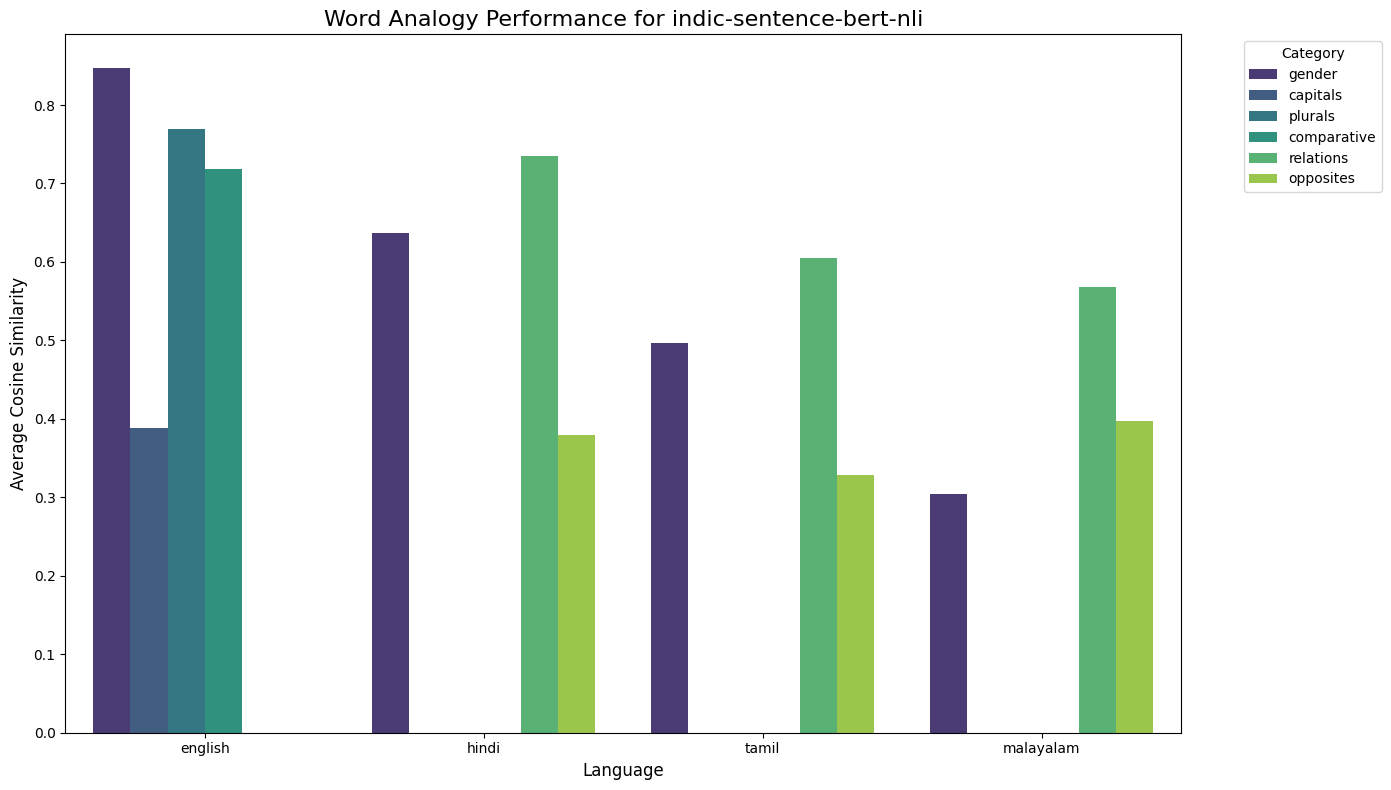

DETAILED ANALOGY EXAMPLES

Model: l3cube-pune/indic-sentence-bert-nli
------------------------------------------

  English Analogies:
    Gender (avg similarity: 0.848):
      son - boy + girl = daughter → 0.920
      actor - man + woman = actress → 0.886
      brother - boy + girl = sister → 0.869
    Capitals (avg similarity: 0.388):
      tokyo - japan + china = beijing → 0.528
      madrid - spain + portugal = lisbon → 0.488
      moscow - russia + brazil = brasilia → 0.447
    Plurals (avg similarity: 0.769):
      book - books + pen = pens → 0.859
      foot - feet + tooth = teeth → 0.811
      cat - cats + dog = dogs → 0.787
    Comparative (avg similarity: 0.719):
      big - bigger + small = smaller → 0.769
      hot - hotter + cold = colder → 0.755
      good - better + bad = worse → 0.707

  Hindi Analogies:
    Gender (avg similarity: 0.637):
      raja - aadmi + aurat = rani → 0.740
      pita - aadmi + aurat = mata → 0.684
      pati - aadmi + aurat = patni → 0.663
    R

In [ ]:
if __name__ == '__main__':
    INDIC_SBERT_MODEL = 'l3cube-pune/indic-sentence-bert-nli'
    evaluator = WordAnalogyEvaluator()
    model_wrapper = ModelWrapper(INDIC_SBERT_MODEL)
    evaluator.run_full_evaluation(model_wrapper)